# Foraging locust with dynamical systems (dynamical system class)

There are four notebooks on the dynamical systems analysis of the locust data, which should be read in the following order:

- [locust_ds_data.ipynb](./locust_ds_data.ipynb)

- [locust_ds_class.ipynb](./locust_ds_class.ipynb)

- [locust_ds_validate.ipynb](./locust_ds_validate.ipynb)

- [locust_ds_interpret.ipynb](./locust_ds_interpret.ipynb)

This is a continuation of the material covered in [locust_ds_data.ipynb](./locust_ds_data.ipynb). Having constructed compartmentalized data in [locust_ds_data.ipynb](./locust_ds_data.ipynb), we now move to building a Bayesian dynamical system and calibrating it. We're modeling the rates at which locusts move between compartments as a function of random diffusion/wandering, and also attraction to locations of feeding or non-feeding locusts. Then, we calibrate the dynamical systems models in a Bayesian setting using the datasets to determine to what extent the movement of locusts is explained by random wandering vs attraction to other locusts.


There are three main processes contributing to the flow of locusts between compartments, wandering, attraction to non-feeding locusts, and attraction to feeding locusts.

$\frac{d\vec{X}}{dt} = wandering(\vec{X}) + attraction_{non\text{-}feeding\,\,locust}(\vec{X}) + attraction_{feeding\,\, locus}(\vec{X})$

- $wandering(\vec{X})$ captures the flux that arises from exploration: some fraction of locust at a given comparment leave to explore other compartments. The DS employs four corresponding coefficients:
    - `w_sides` for exploring between left and right.
    - `w_outside` for moving either from feed to search or from search to edge.
    - `w_inside` for moving from edge to search
    - `w_feed` for moving from search to feed.

So, for instance, the wandering contribution to the derivative $\frac{d\, X_{edge\_l}}{dt}$ is:

$$
 -w_{sides} X_{edge\_l}  + w_{sides} X_{edge\_r} - w_{inside}X_{edge\_l} + w_{outside}X_{search\_l}
$$ 

- $attraction_{non\text{-}feeding\,\,locust}(\vec{X})$ captures the flux resulting from agents' moves being influenced by the mere presence of other locust at a potential target compartment. To capture this, we have the following product coefficients in the system:
  
  - `a_edge`: attraction of the locust in search to those in edge.
  - `a_search`: attraction of the locust in feed or edge to those in search.
  - `a_r` and `a_l`: attraction of locusts between sides within search/edge (unlike `w_sides` here we need to separate left from right to avoid terms cancelling each other, in practice their posterior distributions are very similar).
  
Continuing our example of contributions to $\frac{d\, X_{edge\_l}}{dt}$, this sort of attraction contributes as follows:

$$
 - a_{search} X_{edge\_l} X_{search\_l} + a_{edge} X_{search\_l} X_{edge\_l} - a_r X_{edge\_l} X_{edge\_r} + a_l X_{edge\_r} X_{edge\_l}
$$

- $attraction_{feeding\,\, locus}(\vec{X})$: Finally, we capture the additional attraction of locust to feeding locust, using `a_feed`, which represents how seeing other locust feed impacts locust movements from edge to search and from search to feed. 

Putting it all together:

$$
\begin{split}
\frac{{d\,\text{{edge\_l}}}}{{dt}} &= -w_{\text{sides}} X_{\text{edge\_l}}  %1-
+ w_{\text{sides}} X_{\text{edge\_r}} %2+
- a_{\text{r}} X_{\text{edge\_l}} X_{\text{edge\_r}} %3-
+ a_{\text{l}} X_{\text{edge\_r}} X_{\text{edge\_l}} - \\ %4+
& \quad w_{\text{inside}} X_{\text{edge\_l}}  %5-
- a_{\text{search}} X_{\text{edge\_l}} X_{\text{search\_l}} - %7-
a_{\text{feed}} X_{\text{edge\_l}} X_{\text{feed\_l}} + % 9-
w_{\text{outside}} X_{\text{search\_l}} + \\ %11+
& \quad a_{\text{edge}} X_{\text{search\_l}} X_{\text{edge\_l}}  %13+
+ \epsilon 
+ \\
%-----------------------------
\frac{{d\,\text{{edge\_r}}}}{{dt}} &= -w_{\text{sides}} X_{\text{edge\_r}} %2-
+ w_{\text{sides}} X_{\text{edge\_l}} + %1+
a_{\text{r}} X_{\text{edge\_l}} X_{\text{edge\_r}} % 3+
- a_{\text{l}} X_{\text{edge\_r}} X_{\text{edge\_l}} - \\  %4-
& \quad w_{\text{inside}} X_{\text{edge\_r}} - %6-
a_{\text{search}} X_{\text{edge\_r}} X_{\text{search\_r}} %8-
- a_{\text{feed}} X_{\text{edge\_r}} X_{\text{feed\_r}} + %10-
w_{\text{outside}} X_{\text{search\_r}} + \\ %12+
& \quad a_{\text{edge}} X_{\text{search\_r}} X_{\text{edge\_r}} %14+
 + \epsilon \\
 %----------------------------
\frac{{d\,\text{{search\_l}}}}{{dt}} &= w_{\text{inside}} X_{\text{edge\_l}} %5+
+ a_{\text{search}} X_{\text{edge\_l}} X_{\text{search\_l}}  %7+
+ a_{\text{feed}} X_{\text{edge\_l}} X_{\text{feed\_l}} - \\  %9+
& \quad w_{\text{outside}} X_{\text{search\_l}} -  %11-
w_{\text{sides}} X_{\text{search\_l}} + %15-
w_{\text{sides}} X_{\text{search\_r}} - \\ %16+
& \quad w_{\text{feed}} X_{\text{search\_l}} - %19-
a_{\text{r}} X_{\text{search\_l}} X_{\text{search\_r}} + %17-
a_{\text{l}} X_{\text{search\_r}} X_{\text{search\_l}} - \\  %18+
& \quad a_{\text{edge}} X_{\text{search\_r}} X_{\text{edge\_r}}  %13-
- a_{\text{feed}} X_{\text{search\_l}} X_{\text{feed\_l}}  % 21-
+  w_{\text{outside}} X_{\text{feed\_l}}  %23+
+ a_{\text{search}} X_{\text{search\_l}} X_{\text{feed\_l}} %25+
+ \epsilon \\
%--------------------------
\frac{{d\,\text{{search\_r}}}}{{dt}} &= w_{\text{inside}} X_{\text{edge\_r}}  %6+
+ a_{\text{search}} X_{\text{edge\_r}} X_{\text{search\_r}} + % 8+
a_{\text{feed}} X_{\text{edge\_r}} X_{\text{feed\_r}} - \\ %10+
& \quad w_{\text{outside}} X_{\text{search\_r}} %12-
- w_{\text{sides}} X_{\text{search\_r}} + %16-
w_{\text{sides}} X_{\text{search\_l}} - \\ %15+
& \quad w_{\text{feed}} X_{\text{search\_r}} - %20-
a_{\text{l}} X_{\text{search\_r}} X_{\text{search\_l}} + %18-
a_{\text{r}} X_{\text{search\_l}} X_{\text{search\_r}} - \\ %17+
& \quad a_{\text{edge}} X_{\text{search\_l}} X_{\text{edge\_l}} - %14-
a_{\text{feed}} X_{\text{search\_r}} X_{\text{feed\_r}} %22-
+  w_{\text{outside}} X_{\text{feed\_r}}  %24+
+ a_{\text{search}} X_{\text{search\_r}} X_{\text{feed\_r}} %26+
+ \epsilon \\
%---------------------
\frac{{d\,\text{{feed\_l}}}}{{dt}} &= w_{\text{feed}} X_{\text{search\_l}} %19+
+ a_{\text{feed}} X_{\text{search\_l}} X_{\text{feed\_l}} - \\ %21+
& \quad w_{\text{outside}} X_{\text{feed\_l}} -  %23-
a_{\text{search}} X_{\text{feed\_l}} X_{\text{search\_l}}  %25-
+ \epsilon \\
\frac{{d\,\text{{feed\_r}}}}{{dt}} &= w_{\text{feed}} X_{\text{search\_r}} + %20+
a_{\text{feed}} X_{\text{search\_r}} X_{\text{feed\_r}} - \\ %22_
& \quad w_{\text{outside}} X_{\text{feed\_r}} -  %24-
a_{\text{search}} X_{\text{feed\_r}} X_{\text{search\_r}} %26-
+ \epsilon \\
\end{split}
$$

In [1]:
import os
import time

import pyro
import seaborn as sns
import torch

pyro.settings.set(module_local_params=True)

sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import seaborn as sns
import torch

from collab.foraging import locust as lc

smoke_test = "CI" in os.environ
start = 30
end = start + 2 if smoke_test else start + 12
num_samples = 10 if smoke_test else 150
num_lines = 5 if smoke_test else 100
num_iterations = 10 if smoke_test else 1500
notebook_starts = time.time()

The dynamics are described in the `LocustDynamics` class, which then is used within the `LocustDS` class for a range of downstream tasks. `LocustDynamics` contains the deterministic ODEs in its `forward()` method, uncertainty about the parameters in the `bayesian_locust` model, futher uncertainty about observations within `locust_noisy_model`. Simulating forward is made available by the `simulated_bayesian_locust` model, and the conditioned model is expressed as `conditioned_locust_model`. That class also includes a few handy plotting functions.

The `LocustDS` class puts `LocustDynamics` to downstream use by connecting it with particular training and validation datasets, simulating forward with the same initial states as in the dataset using `simulate_trajectories()`, allowing for the extraction of prior samples using `get_prior_samples()`, running inference using `run_inference()`, posterior check using `evaluate()`, and validation using `validate()`. It also makes related visualizations possible. We will ilustrate its uses in the next few cells.

In [2]:
# this instantiates the dynamics,
# the data will be used in calibration later on

locds = lc.LocustDS(
    data_code="15EQ20191202",
    start=start,
    end=end,
)

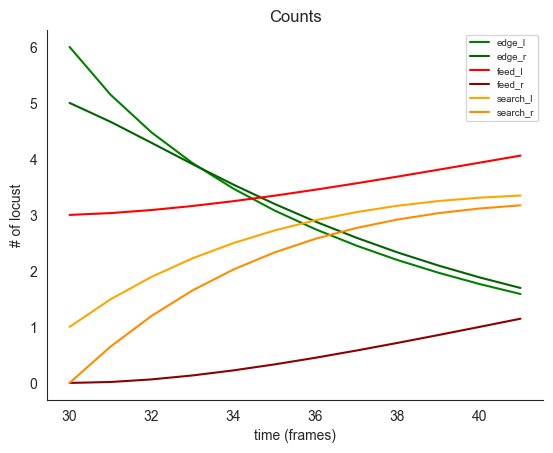

In [3]:
# before we calibrate
# we already can simulate forward by passing some
# parameters of our choice

# a_r, a_l, a_edge, a_search, a_feed
true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01])

# w_sides, w_inside, w_outside, w_feed
true_wander = torch.tensor([0.2, 0.1, 0.01, 0.05])

# by default we take the initial state from the data
# the user can pass `init_state=...` argument
locds.simulate_trajectories(
    true_attraction=true_attraction,
    true_wander=true_wander,
)


locds.plot_simulated_trajectories()

For inference we use the `bayesian_locust` model, which specifies priors for the parameter value vectors. 

```python
def bayesian_locust(base_model=LocustDynamics) -> Dynamics[torch.Tensor]:
    with pyro.plate("attr", size=5):
        attraction = pyro.sample(
            "attraction", dist.Uniform(0.00001, 0.1)
        )  
    with pyro.plate("wond", size=4):
        wander = pyro.sample(
            "wander", dist.Uniform(0.00001, 0.3)
        )  
    locust_model = base_model(attraction, wander)
```

We chose the priors to be comfortably wide, but we needed to constrained the search to avoid instability when using dynamical system solvers. As we will later see, posterior marginal densities lie comfortably within the priors, which strongly suggests these constraints are not damaging.

We can sample the priors using our `locds`, object, and we can also run inference, training the model on the data. Then, the `posterior_check` method allows us to inspect the result.

In [4]:
locds.get_prior_samples(num_samples=num_samples, force=False)

# note, if you run with your own data, use force=True.
# Here we don't use force as we use pre-comupted samples
# obtained in the training and validation for multiple models
# which takes a long time to run.

# we plot prior samples later, when we contrast
# them with the posterior samples after training

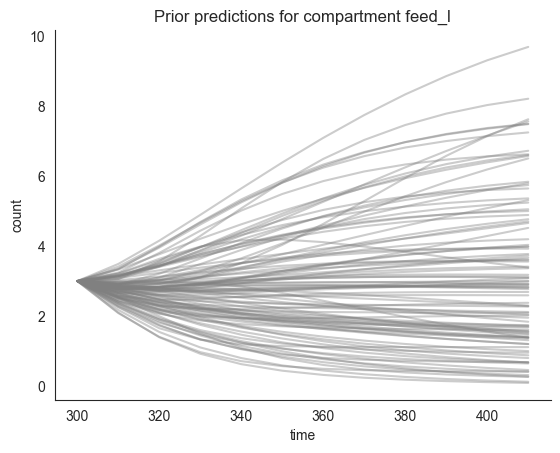

In [5]:
# once you get prior samples
# locds.prior_samples are available for downstream use
# for instance, to plot the prior predictions for a compartment
# using `plot_multiple_trajectories`.

locds.plot_multiple_trajectories("feed_l", num_lines=num_lines, priors=True)

In [6]:
locds.run_inference(
    "length",
    num_iterations=num_iterations,
    num_samples=num_samples,
    lr=0.0005,
    # force=True,
    save=True,
)

# if you inspect the convergence by setting force=True, save = False,
# notice loss drops but the range of sites visited is still fairly wide
# this is because small changes in params can lead to large changes in
# a dynamical system, so loss even with low lr is a bit jumpy

Loading inference samples


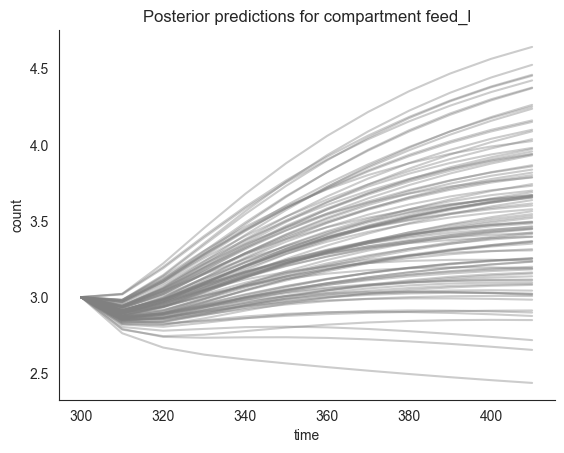

In [7]:
# once you run inference, the posterior samples are available as
# locds.samples, also available for downstream use, such as plotting

locds.plot_multiple_trajectories("feed_l", num_lines=num_lines, priors=False)

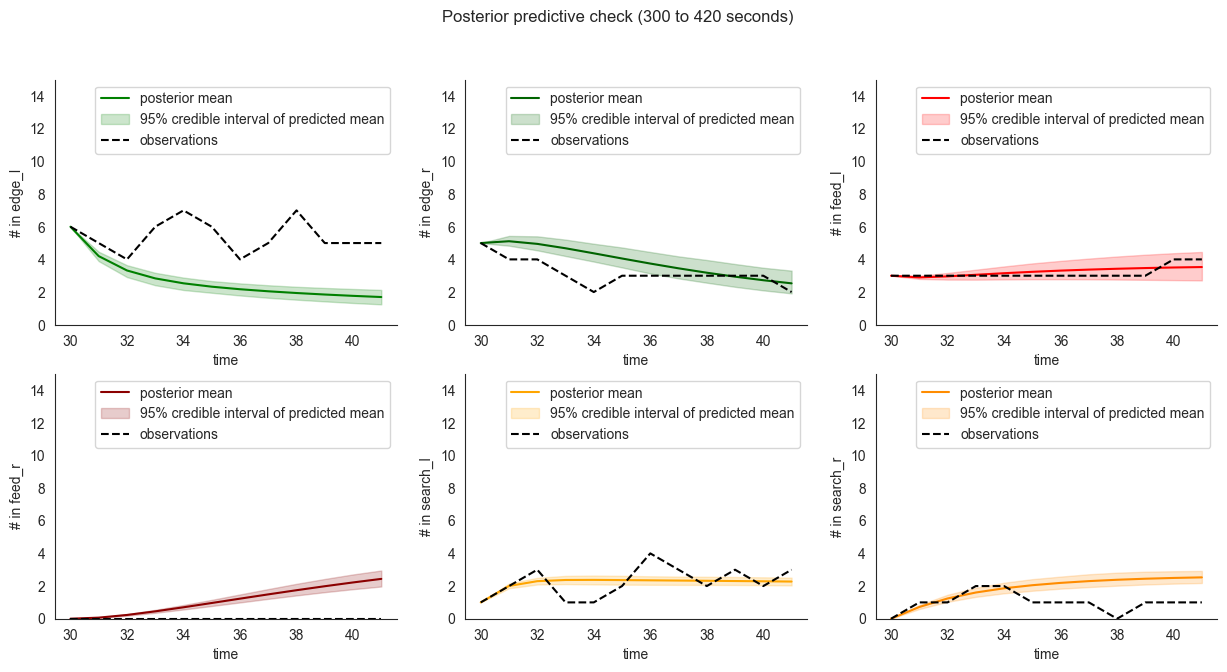

In [8]:
# now we compare the date (black, dashed) to
# mean predictions obtained from the posterior samples,
# the shaded area is the 95% credible interval of the mean
# and does not represent the variation in observations themselves
# which can be inspected using `.plot_multiple_trajectories()`

locds.posterior_check()

We can also use the class to compute standard performance measures - first, on the training set, then on the validation dataset. In gray we plot the residuals obtained using the null model which predicts a constant uniform distribution of locusts.

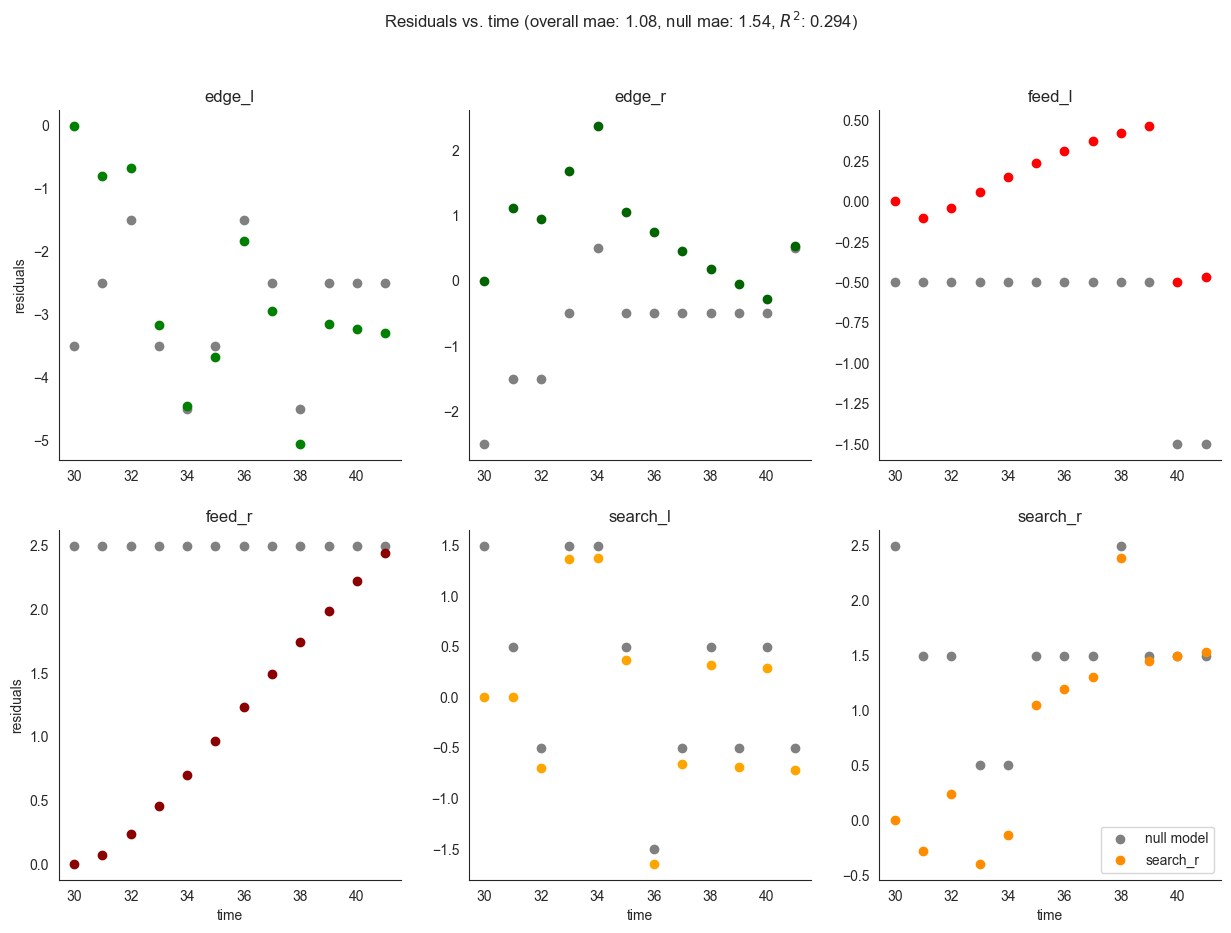

In [9]:
locds.evaluate(samples=locds.samples, subset=locds.subset)

Now we can compare the prior and posterior estimates for some parameters; Suppose we are interested in $w_{feed}$, that is the size of the exploration of towards feeding ratio coefficient - at each time step (we made them 10 seconds each) the model expects on average around 18% of locusts in search to move towards food just because they are exploring. On the other hand, $a_{search}$ is the product coefficient for being attracted by the presence of non-feeding locust at a neighboring compartment, and the model expects on average $0.035 *$(count at target)% of locust at a given compartment to move away for this reason.


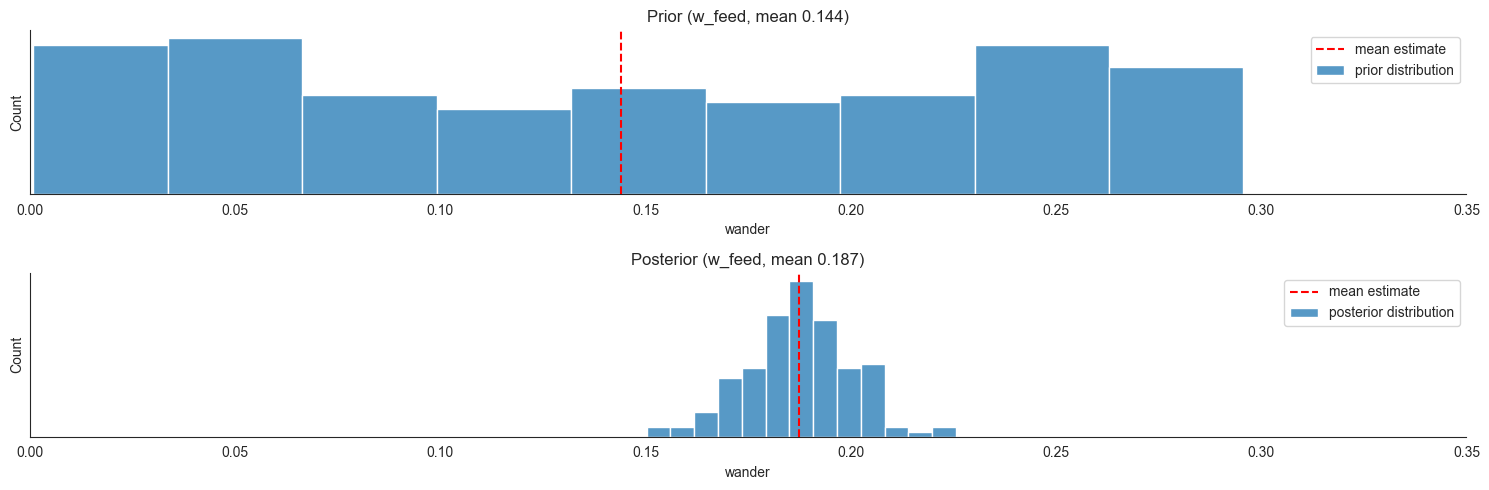

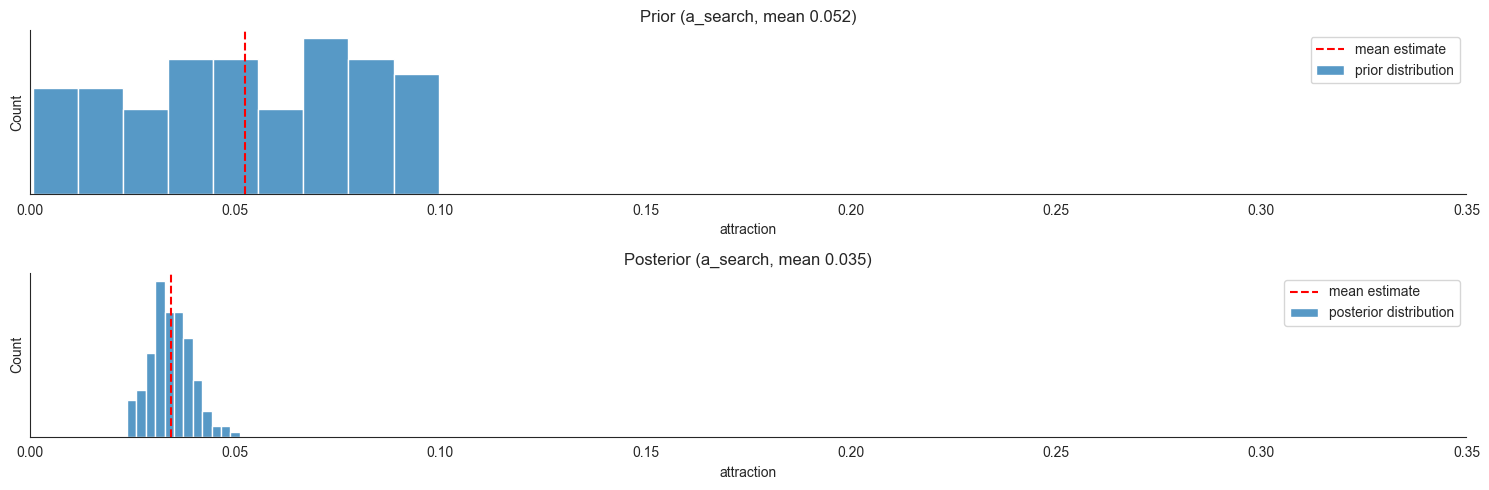

In [10]:
locds.plot_param_estimates(3, 3, xlim=0.35)

We also evaluate the validation data performance of the model we trained. Mean absolute error, as expected increases a bit as compared to the training set, but is still better than that of the null model.

Loading validation samples


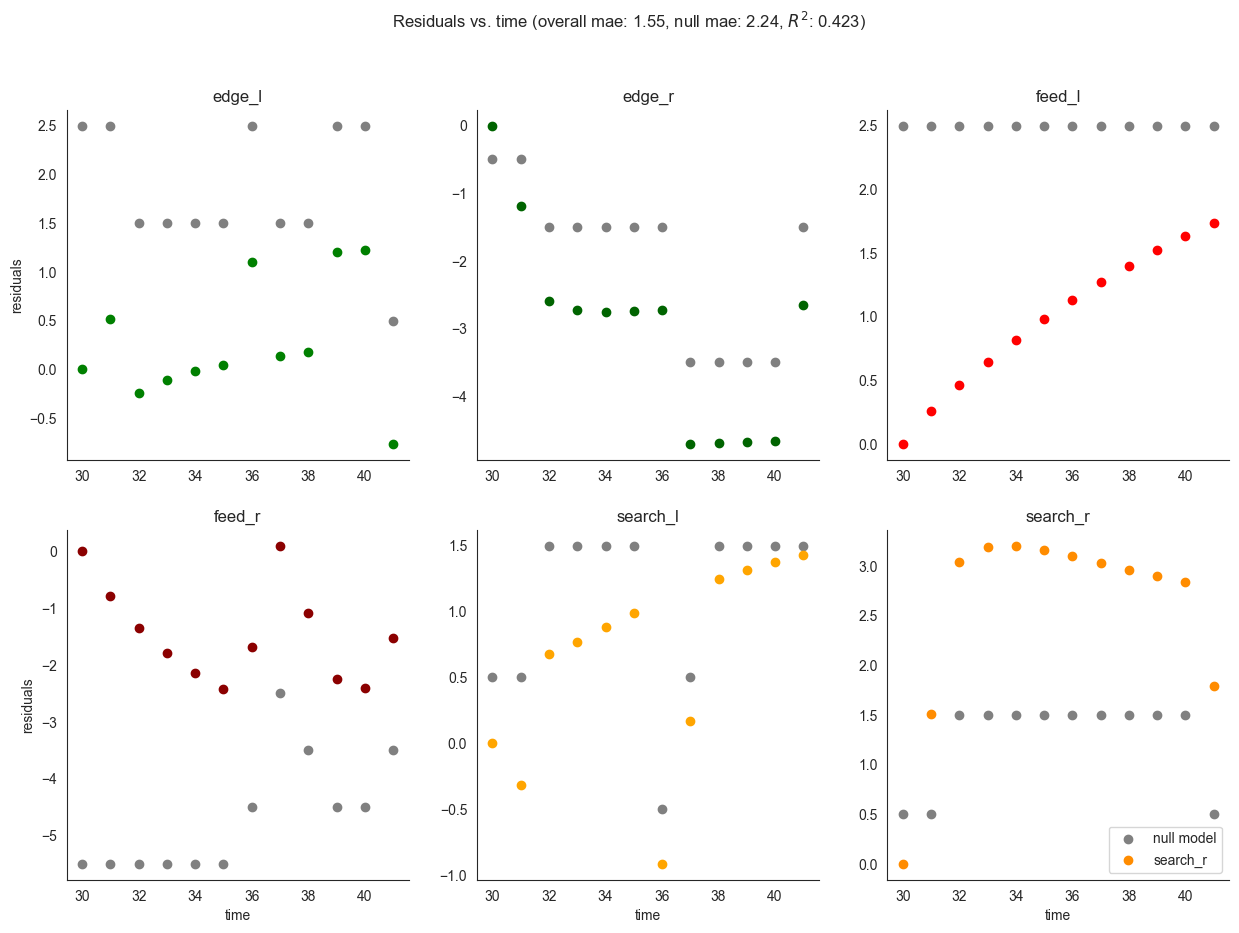

In [11]:
locds.validate(
    validation_data_code="15EQ20191205",
    num_iterations=num_iterations,
    num_samples=num_samples,
)  # , force = True, save = True)

We can also inspect predicted means as compared to the validation dataset. As expected, the model performance on the validation set is somewhat worse than on the training set itself.

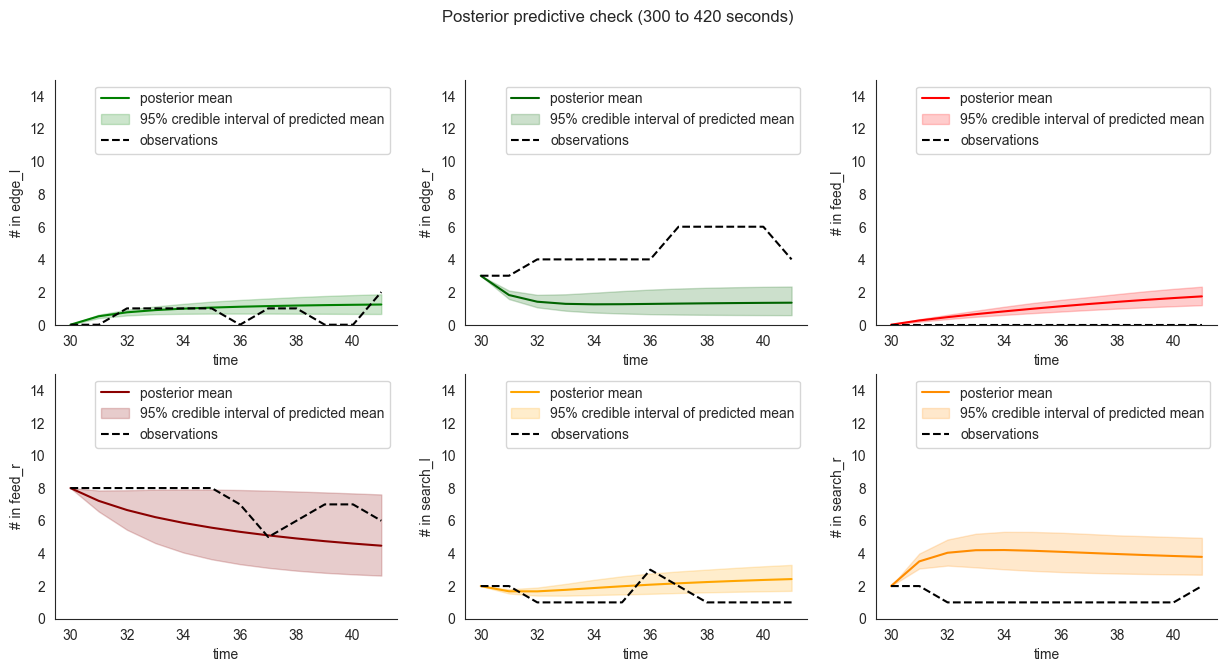

In [12]:
locds.posterior_check(
    samples=locds.v_samples, subset=locds.v_subset, save=False
)  # this also might a png file in docs/figures if save=True

In [13]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 2.7981300354003906 seconds, that is  0.04663550059000651 minutes to run
